In [1]:
#Geneu Kimm and Steven Ren
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [2]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/06 22:41:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#q1
banks_df = spark.read.csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv", header=True, inferSchema=True)
banks_rdd = banks_df.rdd
filtered_rdd = banks_rdd.filter(lambda row: "first" in row["respondent_name"].lower())
count = filtered_rdd.count()
count

525

In [4]:
#q2
banks_panda = banks_df.toPandas()
count = 0
for name in banks_panda['respondent_name']:
    name = name.lower()
    if "first" in name:
        count +=1
count

525

In [5]:
#q3
# example for lower and find first source: https://stackoverflow.com/questions/14908142/sql-like-search-string-starts-with
banks_df.write.saveAsTable("banks",mode="overwrite")
spark.sql("""
SELECT *
FROM banks
WHERE LOWER(respondent_name) LIKE "%first%" 
""").count()

23/11/06 22:42:05 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/06 22:42:05 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/11/06 22:42:10 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/11/06 22:42:10 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.23.0.4
23/11/06 22:42:11 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/11/06 22:42:17 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/11/06 22:42:17 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
23/11/06 22:42:17 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/06 22:42:17 W

525

In [11]:
loans_df = spark.read.csv("hdfs://nn:9000/hdma-wi-2021.csv", header=True, inferSchema=True)
loans_df.write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite")

df = spark.read.csv(f"hdfs://nn:9000/ethnicity.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("ethnicity")
df = spark.read.csv(f"hdfs://nn:9000/race.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("race")
df = spark.read.csv(f"hdfs://nn:9000/sex.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("sex")
df = spark.read.csv(f"hdfs://nn:9000/states.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("states")
df = spark.read.csv(f"hdfs://nn:9000/counties.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("counties")
df = spark.read.csv(f"hdfs://nn:9000/tracts.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("tracts")
df = spark.read.csv(f"hdfs://nn:9000/action_taken.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("action_taken")
df = spark.read.csv(f"hdfs://nn:9000/denial_reason.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("denial_reason")
df = spark.read.csv(f"hdfs://nn:9000/loan_type.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("loan_type")
df = spark.read.csv(f"hdfs://nn:9000/loan_purpose.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("loan_purpose")
df = spark.read.csv(f"hdfs://nn:9000/preapproval.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("preapproval")
df = spark.read.csv(f"hdfs://nn:9000/property_type.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("property_type")

In [7]:
spark.sql("SHOW TABLES").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|        banks|      false|
|  default|        loans|      false|
|         | action_taken|       true|
|         |     counties|       true|
|         |denial_reason|       true|
|         |    ethnicity|       true|
|         | loan_purpose|       true|
|         |    loan_type|       true|
|         |  preapproval|       true|
|         |property_type|       true|
|         |         race|       true|
|         |          sex|       true|
|         |       states|       true|
|         |       tracts|       true|
+---------+-------------+-----------+



In [8]:
#q4
tables = spark.sql("SHOW TABLES").toPandas()
dict_q4 = dict(zip(tables["tableName"], tables["isTemporary"]))

dict_q4

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [9]:
#q5
df_q5 = spark.sql("""
    SELECT *
    FROM banks
    INNER JOIN loans
    ON banks.lei_2020 = loans.lei
    WHERE banks.respondent_name = 'University of Wisconsin Credit Union'
""")

df_q5.count()

19739

In [10]:
#q6
df_q5.explain("formatted")

# 1. Which table is sent to every executor via a BroadcastExchange operation?
# The 'banks' table is sent to every executor via a BroadcastExchange operation, seen in (3) BroadcastExchange, the inputs are fields from the 'banks' table.

# 2. Does the plan involve HashAggregates (depending on how you write the query, it may or may not)? If so, which ones?
# The plan does not invilve hashAgreegates, it is not shown.

== Physical Plan ==
AdaptiveSparkPlan (7)
+- BroadcastHashJoin Inner BuildLeft (6)
   :- BroadcastExchange (3)
   :  +- Filter (2)
   :     +- Scan parquet spark_catalog.default.banks (1)
   +- Filter (5)
      +- Scan parquet spark_catalog.default.loans (4)


(1) Scan parquet spark_catalog.default.banks
Output [5]: [respondent_name#52, arid_2017#53, lei_2018#54, lei_2019#55, lei_2020#56]
Batched: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,University of Wisconsin Credit Union), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,arid_2017:string,lei_2018:string,lei_2019:string,lei_2020:string>

(2) Filter
Input [5]: [respondent_name#52, arid_2017#53, lei_2018#54, lei_2019#55, lei_2020#56]
Condition : ((isnotnull(respondent_name#52) AND (respondent_name#52 = University of Wisconsin Credit Union)) AND isnotnull(lei_2020#56))

(3) BroadcastExchange
Input [5]: [respondent_name#52

In [85]:
#q7
top_counties = spark.sql("""
    SELECT counties.NAME, AVG(loans.interest_rate) as avg_interest_rate
    FROM loans
    INNER JOIN banks
    ON loans.lei = banks.lei_2020
    INNER JOIN counties
    ON loans.county_code = counties.STATE*1000 + counties.COUNTY
    WHERE banks.respondent_name = 'Wells Fargo Bank, National Association'
    GROUP BY counties.NAME
    ORDER BY COUNT(*) DESC
    LIMIT 10
""")
# top_counties.show()

top_counties_dict = {row.NAME: row.avg_interest_rate for row in top_counties.collect()}

top_counties_dict

{'Milwaukee': 3.1173465727097907,
 'Waukesha': 2.8758225602027756,
 'Washington': 2.851009389671362,
 'Dane': 2.890674955595027,
 'Brown': 3.010949119373777,
 'Racine': 3.099783715012723,
 'Outagamie': 2.979661835748792,
 'Winnebago': 3.0284761904761908,
 'Ozaukee': 2.8673765432098772,
 'Sheboygan': 2.995511111111111}

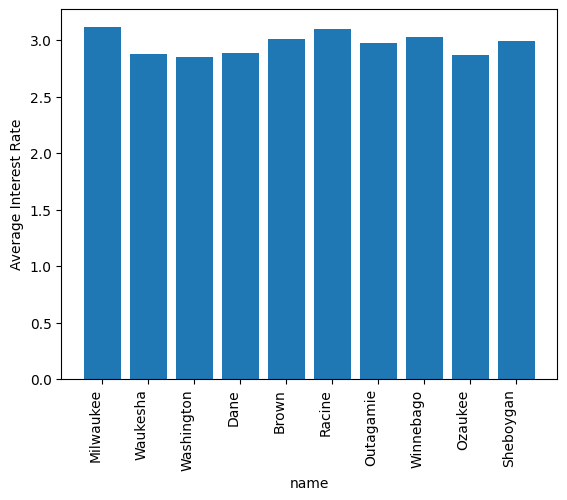

In [100]:
import matplotlib.pyplot as plt

plt.bar(top_counties_dict.keys(), top_counties_dict.values())
plt.xlabel('name')
plt.ylabel('Average Interest Rate')
plt.xticks(rotation=90, ha="right")  # rotate x-axis labels

plt.show()

In [107]:
#q8
example = spark.sql("""
    SELECT county_code, AVG(interest_rate) as avg_interest_rate
    FROM loans
    GROUP BY county_code
""")

example.explain("formatted")

example_lei = spark.sql("""
    SELECT lei, AVG(interest_rate) as avg_interest_rate
    FROM loans
    GROUP BY lei
""")

example_lei.explain("formatted")

# If a network transfer (network I/O) is necessary for one query but not the other, write a comment explaining why. You might want to look back at how you loaded the data to a Hive table earlier.

# Response: A network trasnfer (network I/O0 was used for GROUP BY lei query but not for GROUP BY county_code, an exchange operation was used for GROUP BY lei. It means that a shuffle exhange occured and data was moved around.

== Physical Plan ==
AdaptiveSparkPlan (4)
+- HashAggregate (3)
   +- HashAggregate (2)
      +- Scan parquet spark_catalog.default.loans (1)


(1) Scan parquet spark_catalog.default.loans
Output [2]: [county_code#2128, interest_rate#2147]
Batched: true
Bucketed: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/loans]
ReadSchema: struct<county_code:string,interest_rate:string>
SelectedBucketsCount: 8 out of 8

(2) HashAggregate
Input [2]: [county_code#2128, interest_rate#2147]
Keys [1]: [county_code#2128]
Functions [1]: [partial_avg(cast(interest_rate#2147 as double))]
Aggregate Attributes [2]: [sum#7215, count#7216L]
Results [3]: [county_code#2128, sum#7217, count#7218L]

(3) HashAggregate
Input [3]: [county_code#2128, sum#7217, count#7218L]
Keys [1]: [county_code#2128]
Functions [1]: [avg(cast(interest_rate#2147 as double))]
Aggregate Attributes [1]: [avg(cast(interest_rate#2147 as double))#7212]
Results [2]: [county_code#2128, avg(cast(interest_rate#2147 as double

In [137]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

spark = SparkSession.builder.appName("LoanPrediction").getOrCreate()

loans = spark.table("loans")

df = loans.select(
    col("loan_amount").cast("double"),
    col("income").cast("double"),
    col("interest_rate").cast("double"),
    when(col("action_taken") == 1, 1).otherwise(0).alias("approval")
)

df = df.na.fill(0.0)

train, test = df.randomSplit([0.8, 0.2], seed=41)

In [139]:
#q9
train_df = train.toPandas()
count = 0
for approval in train_df['approval']:
    if approval == 1:
        count +=1

count

242868

In [140]:
#q10
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

va = VectorAssembler(inputCols=["loan_amount", "income", "interest_rate"], outputCol="features")
train = va.transform(train)
test = va.transform(test)

dt = DecisionTreeClassifier(labelCol='approval', featuresCol='features', maxDepth=5)

model = dt.fit(train)

predictions = model.transform(test)

correct_predictions = predictions.filter(col("approval") == col("prediction")).count()
total_predictions = predictions.count()
accuracy = correct_predictions / total_predictions

accuracy

0.8931644386068411